# More Fun with convolutional networks
> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


This notebook demonstrates one of the many cool applications of convolutional neural networks.
We will work with an augmented version of the MNIST data set.
In the data the each mnist digit (20x20 pixels) has been placed randomly in a 60x60 canvas.
To make the task harder each canvas has then been cluttered with small pieces of digits.
In this task it is helpful for a network if it can focus only on the digit and ignore the rest.


The ``TransformerLayer`` lets us do this.
The transformer layer learns an affine transformation which lets the network zoom, rotate and skew.
If you are interested you should [read the paper](https://arxiv.org/abs/1506.02025), but the main idea is that you can let a small convolutional network determine the parameters of the affine transformation.
You then apply the affine transformation to the input data.
Usually this also involves downsampling which forces the model to zoom in on the relevant parts of the data. 
After the affine transformation we can use a larger conv net to do the classification. 
This is possible because you can backprop through a an affine transformation if you use bilinear interpolation.

### Get the data
If you don't already have the data uncomment and run the line below.
The `!` makes the command run as if it was typed into the terminal.
If this doesn't work download it manually.

In [39]:
# !wget -N https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz

Load and visualize the data

Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


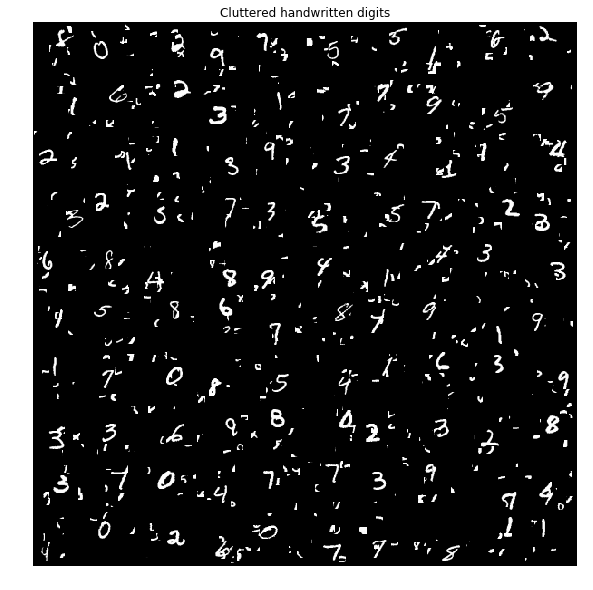

In [40]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys

# I added the above

import numpy as np
from mnist_cluttered import load_data

DIM = 60

data = load_data()
idx = 0
canvas = np.zeros((DIM*10, 10*DIM))
for i in range(10):
    for j in range(10):
        canvas[i*DIM:(i+1)*DIM, j*DIM:(j+1)*DIM] = data['X_train'][idx].reshape((DIM, DIM))
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('Cluttered handwritten digits')
plt.axis('off')

plt.show()

# Dependancies and supporting functions
Loading dependancies and supporting functions by running the code block below.

In [41]:
import os
import matplotlib
np.random.seed(123)
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 
from spatial_transformer import transformer

NUM_EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10

In [42]:
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, max_pool2d
pool = max_pool2d
conv = convolution2d
dense = fully_connected
from tensorflow.python.ops.nn import relu, softmax
from tensorflow.python.framework.ops import reset_default_graph

## Building the model

We use a model where the localization network is a two layer convolution network which operates directly on the image input. The output from the localization network is a 6 dimensional vector specifying the parameters in the affine transformation.

If the output from the localization networks is 
```
|t1, t2, t3|
|t4, t5, t6|
```
then 
* t1 and t5 determines zoom, 
* t2 and t4 determines skewness, and 
* t3 and t6 move the center position. 

We set up the transformer layer to initially do the identity transform.
By setting the initial values of the bias vector to 
```
|1, 0, 0|
|0, 1, 0|
```
and the final W of the localization network to all zeros we ensure that in the beginning of training the network works as a pooling layer. 


The output of the localization layer feeds into the transformer layer which applies the transformation to the image input.
In our setup the transformer layer downsamples the input by a factor 3.

Finally a 2 layer convolution layer and 2 fully connected layers calculates the output probabilities.


### The model
![](images/transformer_network.png)

Notice that the tranformer network is both given the matrix calculated by the localization layer and the original input image. The flow of the data is thus actually:
```
Input -> localization_network -> TransformerLayer -> output_network -> predictions
   |                                |
   >--------------------------------^
```


In [43]:
tf.reset_default_graph()
def build_model(x_pl, input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    
    # Setting up placeholder, this is where your data enters the graph!
    l_reshape = tf.transpose(x_pl, [0, 2, 3, 1]) # TensorFlow uses [batch_size, height, widht, depth]

    # make distributed representation of input image for localization network
    loc_l1 = pool(l_reshape, kernel_size=[2, 2], scope="localization_l1")
    loc_l2 = conv(loc_l1, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="localization_l2")
    loc_l3 = pool(loc_l2, kernel_size=[2, 2], scope="localization_l3")
    loc_l4 = conv(loc_l3, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="localization_l4")
    loc_l4_flatten = flatten(loc_l4, scope="localization_l4-flatten")
    loc_l5 = dense(loc_l4_flatten, num_outputs=50, activation_fn=relu, scope="localization_l5")
    
    # set up weights for transformation (notice we always need 6 output neurons)
    with tf.name_scope("localization"):
        W_loc_out = tf.get_variable("localization_loc-out", [50, 6], initializer=tf.constant_initializer(0.0))
        initial = np.array([[1, 0, 0], [0, 1, 0]])
        initial = initial.astype('float32')
        initial = initial.flatten()
        b_loc_out = tf.Variable(initial_value=initial, name='b-loc-out')
        loc_out = tf.matmul(loc_l5, W_loc_out) + b_loc_out

    # spatial transformer
    l_trans1 = transformer(l_reshape, loc_out, out_size=(DIM//3, DIM//3))
    l_trans1.set_shape([None, DIM//3, DIM//3, 1])
    l_trans1_valid = tf.transpose(l_trans1, [0, 2, 3, 1]) # Back into NCHW for validation

    print( "Transformer network output shape: ", l_trans1.get_shape())

    # classification network
    class_l1 = conv(l_trans1, num_outputs=16, kernel_size=[3, 3], scope="classification_l1")
    class_l2 = pool(class_l1, kernel_size=[2, 2], scope="classification_l2")
    class_l3 = conv(class_l2, num_outputs=16, kernel_size=[3, 3], scope="classification_l3")
    class_l4 = pool(class_l3, kernel_size=[2, 2], scope="classification_l4")
    class_l4_flatten = flatten(class_l4, scope="classification_l4-flatten")
    class_l5 = dense(class_l4_flatten, num_outputs=256, activation_fn=relu, scope="classification_l5")
    l_out = dense(class_l5, num_outputs=output_dim, activation_fn=softmax, scope="classification_l-out")

    return l_out, l_trans1_valid

x_pl = tf.placeholder(tf.float32, [None, 1, DIM, DIM], name="input")
model, l_transform = build_model(x_pl, DIM, DIM, NUM_CLASSES)

# y_ is a placeholder variable taking on the value of the target batch.
y_pl = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name="output")
lr_pl = tf.placeholder(tf.float32, shape=[], name="learning-rate")

with tf.name_scope("loss"):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(model+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

# defining our optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr_pl)

# applying the gradients
train_op = optimizer.minimize(cross_entropy)

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.global_variables_initializer())

Transformer network output shape:  (?, 20, 20, 1)


In [44]:
## Launch TensorBoard, and visualize the TF graph
tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
utils.show_graph(tmp_def)

In [45]:
# test the forward pass
dummy_size = 45
x = np.random.normal(0,1, (dummy_size, 1,60,60)).astype('float32') #dummy data

res = sess.run(fetches=model, feed_dict={x_pl: x})

assert res.shape == (dummy_size, 10), "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')


Forward pass successful!


### Training the model
Unfortunately NVIDIA has yet to squeeze a TitanX into a labtop and training convnets on CPU is painfully slow. After 10 epochs you should see that model starts to zoom in on the digits. 

I had to insert the onehot function.

In [46]:
def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

In [47]:
def train_epoch(X, y, learning_rate):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        if i % 10 == 0:
            print(i, end=', ')
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch_tr = X[idx]
        y_batch_tr = y[idx]
        fetches_tr = [train_op, cross_entropy, model]
        feed_dict_tr = {x_pl: X_batch_tr, y_pl: onehot(y_batch_tr, NUM_CLASSES), lr_pl: learning_rate}
        res = sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr)
        cost_batch, output_train = tuple(res[1:3])
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch_tr == preds)
    print("")
    return np.mean(costs), correct / float(num_samples)


def eval_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    pred_list = []
    transform_list = []
    for i in range(num_batches):
        if i % 10 == 0:
            print(i, end=', ')
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch_val = X[idx]
        fetches_val = [model, l_transform]
        feed_dict_val = {x_pl: X_batch_val}
        res = sess.run(fetches=fetches_val, feed_dict=feed_dict_val)
        output_eval, transform_eval = tuple(res)
        pred_list.append(output_eval)
        transform_list.append(transform_eval)
    transform_eval = np.concatenate(transform_list, axis=0)
    preds = np.concatenate(pred_list, axis=0)
    preds = np.argmax(preds, axis=-1)
    acc = np.mean(preds == y)
    print('')
    return acc, transform_eval

In [48]:
valid_accs, train_accs, test_accs = [], [], []
learning_rate=0.0001
print('Number of epochs: %s' % NUM_EPOCHS)

try:
    for n in range(NUM_EPOCHS):
        print("Epoch %d:" % n, end=', ')
        #print('train:', end=', ')
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'], learning_rate)
        #print('valid:', end=', ')
        valid_acc, valid_trainsform = eval_epoch(data['X_valid'], data['y_valid'])
        #print('test:', end=', ')
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]

        # learning rate annealing
        if (n+1) % 20 == 0:
            learning_rate = learning_rate * 0.7
            print("New LR:", learning_rate)

        print("train cost {0:.2}, train acc {1:.2}, val acc {2:.2}, test acc {3:.2}".format(
                train_cost, train_acc, valid_acc, test_acc))
except KeyboardInterrupt:
    pass

Number of epochs: 100
Epoch 0:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
train cost 2.3, train acc 0.12, val acc 0.16, test acc 0.15
Epoch 1:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
train cost 2.2, train acc 0.19, val acc 0.23, test acc 0.23
Epoch 2:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
train cost 2.0, train acc 0.31, val acc 0.42, test acc 0.41
Epoch 3:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
train cost 1.5, train acc 0.5, val acc 0.57, test acc 0.57
Epoch 4:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 

Epoch 38:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
train cost 0.3, train acc 0.9, val acc 0.88, test acc 0.89
Epoch 39:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
New LR: 4.899999999999999e-05
train cost 0.29, train acc 0.91, val acc 0.88, test acc 0.89
Epoch 40:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
train cost 0.29, train acc 0.91, val acc 0.88, test acc 0.89
Epoch 41:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
train cost 0.28, train acc 0.91, val acc 0.88, test acc 0.89
Epoch 42:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 1

test:, 0, 10, 20, 30, 
train cost 0.2, train acc 0.94, val acc 0.9, test acc 0.9
Epoch 76:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
train cost 0.19, train acc 0.94, val acc 0.9, test acc 0.9
Epoch 77:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
train cost 0.19, train acc 0.94, val acc 0.9, test acc 0.9
Epoch 78:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
train cost 0.19, train acc 0.94, val acc 0.9, test acc 0.9
Epoch 79:, train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
valid:, 0, 10, 20, 30, 
test:, 0, 10, 20, 30, 
New LR: 2.4009999999999995e-05
train cost 0.19, train acc 0.94, val acc 0.9, test acc 0.9
Epoch 80:, train:, 0, 10, 20

### Plot errors and zoom

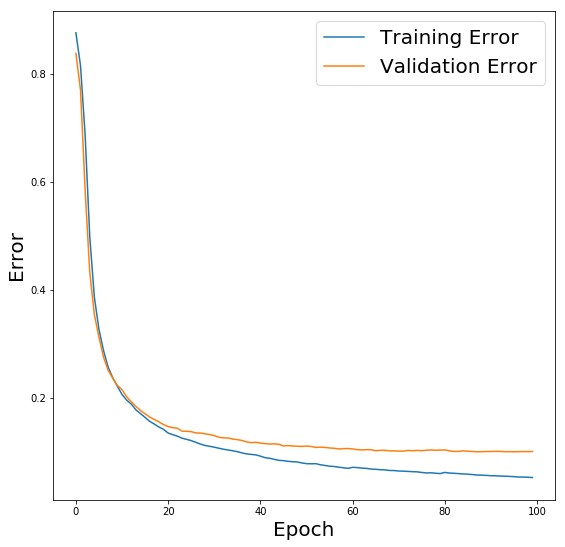

In [49]:
plt.figure(figsize=(9,9))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

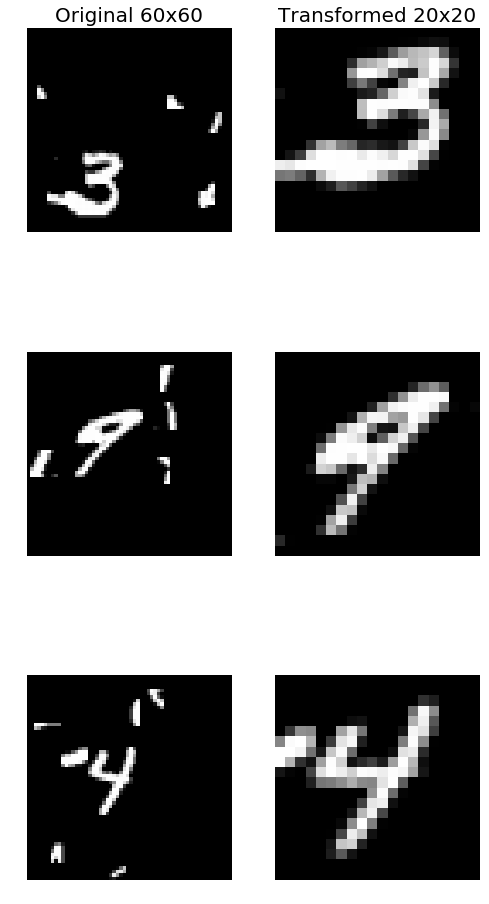

In [50]:
plt.figure(figsize=(7,14))
for i in range(3):
    plt.subplot(321+i*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(322+i*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3).T, cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
    
    
plt.tight_layout()
plt.show()